In [1]:
from global_config import config

import matplotlib.pyplot as plt

from tqdm import tqdm
import pandas as pd
import xarray as xr
import numpy as np
import wget
import os

import cartopy.crs as ccrs
import rioxarray
import cartopy

# xarray version 2025.1.
# pandas version 2.2.3.
# numpy version 2.2.2.

def flatten_list(ls):
    return [item for sublist in ls for item in sublist]


data_dir = config.get_property('data_dir')
data_dir = os.path.join(data_dir, 'raw')

precip_data_dir = os.path.join(data_dir, 'precipitation')
CHRIPS_data_dir = os.path.join(precip_data_dir, "CHIRPS-2.0")


In [2]:
time_freq   = "daily"
product     = f"global_{time_freq}/netcdf/p05"

save_chirps_dir = os.path.join(CHRIPS_data_dir, product)


In [3]:
# load thai shapefile
import geopandas as gpd

#clipped = xds.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=True)
data_dir        = os.path.join(config.get_property('data_dir'), "raw", "thai_shapefile")#, 'processed')
thai_shp        = gpd.read_file(os.path.join(data_dir, "tha_admbnda_adm1_rtsd_20190221.shp"))
prov_loc_df     = pd.read_csv(os.path.join(config.get_property('data_dir'), "raw", "provinces_climate_region.csv"))
location2region = dict(zip(prov_loc_df.location, prov_loc_df.climatic_region))

prov2reg_2 = {"Sa Kaeo": "Eastern", "Yasothon": "Northeastern",
            "Amnat Charoen": "Northeastern",
            "Bueng Kan": "Northeastern",
            "Mukdahan": "Northeastern",
            "Nong Bua Lam Phu": "Northeastern",
            "Yasothon": "Northeastern"}

thai_shp["ADM1_EN"].replace({"Bangkok": "Krung Thep"}, inplace=True)
thai_shp["region1"] = thai_shp["ADM1_EN"].map(location2region) # provinces with DHF data
thai_shp["region2"] = thai_shp["ADM1_EN"].map(prov2reg_2)       # provinces without DHF data
thai_shp["region"]  = thai_shp["region1"].fillna(thai_shp["region2"])
thai_reg_shp        = thai_shp.copy().dissolve(by='region').reset_index()

bang_shp           = thai_shp[thai_shp.ADM1_EN == "Krung Thep"]
bang_shp["region"] = ["Krung Thep"]
thai_reg_shp      = pd.concat([thai_reg_shp, bang_shp]).reset_index(drop=True)


/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_83828/1938837338.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  thai_shp["ADM1_EN"].replace({"Bangkok": "Krung Thep"}, inplace=True)
/Users/chaosdonkey06/miniconda3/envs/denv_thai/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,region,geometry,Shape_Leng,Shape_Area,ADM1_EN,ADM1_TH,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM1ALT1TH,ADM1ALT2TH,ADM0_EN,ADM0_TH,ADM0_PCODE,date,validOn,validTo,region1,region2
0,Central,"POLYGON ((100.07874 13.4253, 100.07872 13.4252...",1.739908,0.079210,Ang Thong,อ่างทอง,TH15,None,None,None,None,None,Thailand,ประเทศไทย,TH,2019-02-18,2019-02-21,0000/00/00,Central,None
1,Eastern,"MULTIPOLYGON (((100.91732 12.60085, 100.91724 ...",4.941453,0.431484,Chachoengsao,ฉะเชิงเทรา,TH24,None,None,None,None,None,Thailand,ประเทศไทย,TH,2019-02-18,2019-02-21,0000/00/00,Eastern,Eastern
2,Northeastern,"POLYGON ((104.05708 14.34343, 104.05694 14.343...",3.927244,0.275313,Amnat Charoen,อำนาจเจริญ,TH37,None,None,None,None,None,Thailand,ประเทศไทย,TH,2019-02-18,2019-02-21,0000/00/00,Northeastern,Northeastern
3,Northern,"POLYGON ((100.02475 16.19113, 100.02467 16.191...",13.346345,1.900546,Chiang Mai,เชียงใหม่,TH50,None,None,None,None,None,Thailand,ประเทศไทย,TH,2019-02-18,2019-02-21,0000/00/00,Northern,None
4,Southern,"MULTIPOLYGON (((98.31425 7.48062, 98.31433 7.4...",6.751065,0.497077,Chumphon,ชุมพร,TH86,None,None,None,None,None,Thailand,ประเทศไทย,TH,2019-02-18,2019-02-21,0000/00/00,Southern,None
5,Krung Thep,"POLYGON ((100.61389 13.95462, 100.61428 13.954...",2.417227,0.131339,Krung Thep,กรุงเทพมหานคร,TH10,None,None,None,None,None,Thailand,ประเทศไทย,TH,2019-02-18,2019-02-21,0000/00/00,Central,NaN


In [32]:
years = list(range(1981, 2020))

precipitation_df = pd.DataFrame()
for y in years:
    year_df          = pd.read_csv(os.path.join(precip_data_dir, "thailand", f"{y}.csv"), parse_dates=["date"])
    year_df["doy"]   = year_df["date"].apply(lambda x: x.day_of_year)
    year_df["year"]  = year_df["date"].dt.year
    year_df["month"] = year_df["date"].dt.month

    precipitation_df = pd.concat([precipitation_df, year_df])

In [25]:
regions = ['Northeastern', 'Northern', 'Central', 'Eastern', 'Southern', 'Krung Thep']

In [ ]:
precipitation_df.to_csv(os.path.join(precip_data_dir, "thailand", "1981_2019.csv"), index=False)

,date,region,precip,variable,doy,year,month
0,1981-01-01,Central,0.0,precip,1,1981,1
1,1981-01-02,Central,0.0,precip,2,1981,1
2,1981-01-03,Central,0.0,precip,3,1981,1
3,1981-01-04,Central,0.0,precip,4,1981,1
4,1981-01-05,Central,0.0,precip,5,1981,1
...,...,...,...,...,...,...,...
2185,2019-12-27,Krung Thep,0.0,precip,361,2019,12
2186,2019-12-28,Krung Thep,0.0,precip,362,2019,12
2187,2019-12-29,Krung Thep,0.0,precip,363,2019,12
2188,2019-12-30,Krung Thep,0.0,precip,364,2019,12


In [ ]:
# git filter-branch --tree-filter 'rm -rf chirps-v2.0.2010.days_p05.ncoa6dorul.tmp' HEAD



In [ ]:
from utils.plot_utils import create_df_response

region = regions[0]

time_scale = "month" #["month", "doy"]

reg_resp_df = pd.DataFrame()
for region in regions:
    reg_prep_df     =  precipitation_df[precipitation_df.region == region]
    if time_scale == "month":
        reg_prep_df = reg_prep_df.groupby(["year", "month"]).agg({"precip": "sum"}).reset_index()

    reg_piv_prep_df = pd.pivot(reg_prep_df, columns="year", index=time_scale, values="precip").T
    reg_df          = create_df_response(reg_piv_prep_df.to_numpy(),
                                            dates = np.arange(1, len(reg_piv_prep_df.T)+1),
                                            time  = len(reg_piv_prep_df.T))
    reg_df["region"] = region
    reg_resp_df      = pd.concat([reg_resp_df, reg_df])

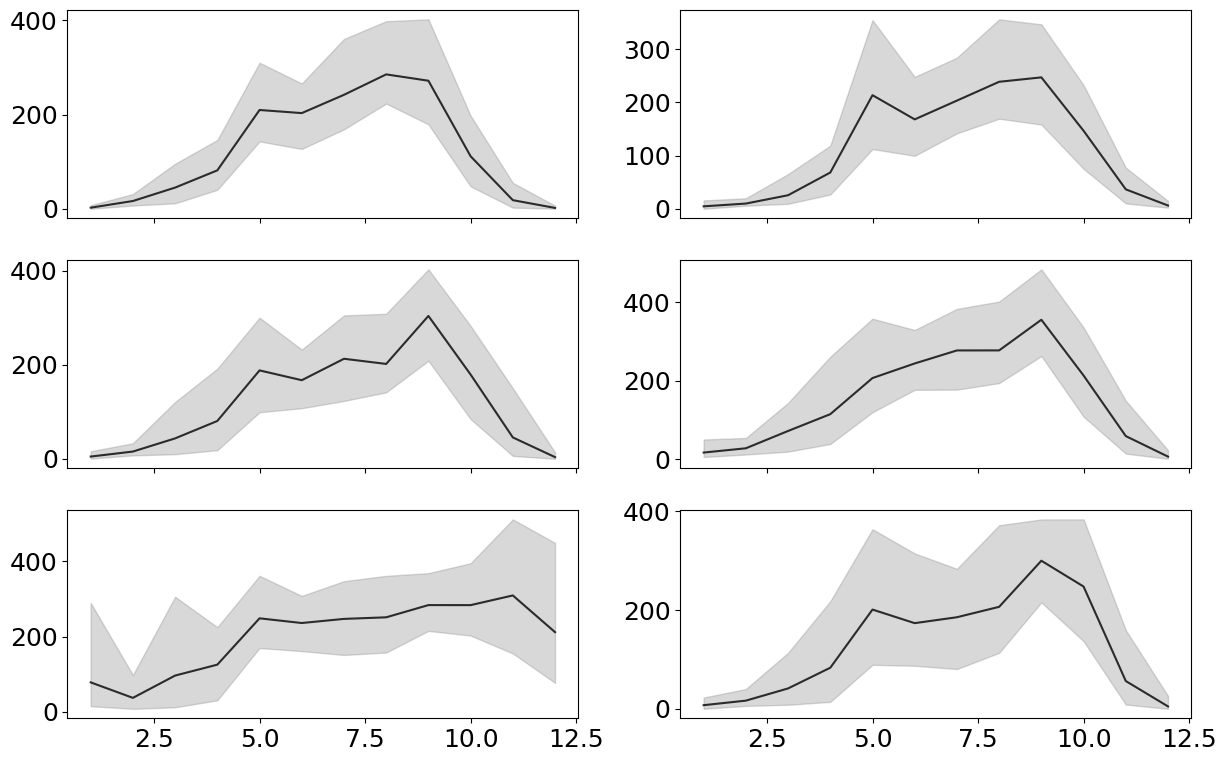

In [66]:
import seaborn as sns

fig, ax = plt.subplots(3, 2, figsize=(14.5, 9.2), sharex=True, sharey=False)

for i_axi, axi in enumerate(ax.flatten()):

    region = regions[i_axi]
    reg_df = reg_resp_df[reg_resp_df.region == region]

    axi.fill_between(reg_df.index, reg_df["low_95"], reg_df["up_95"], color='gray', alpha=0.3)
    axi.plot(reg_df.index, reg_df["mean"], color='black', alpha=0.8)


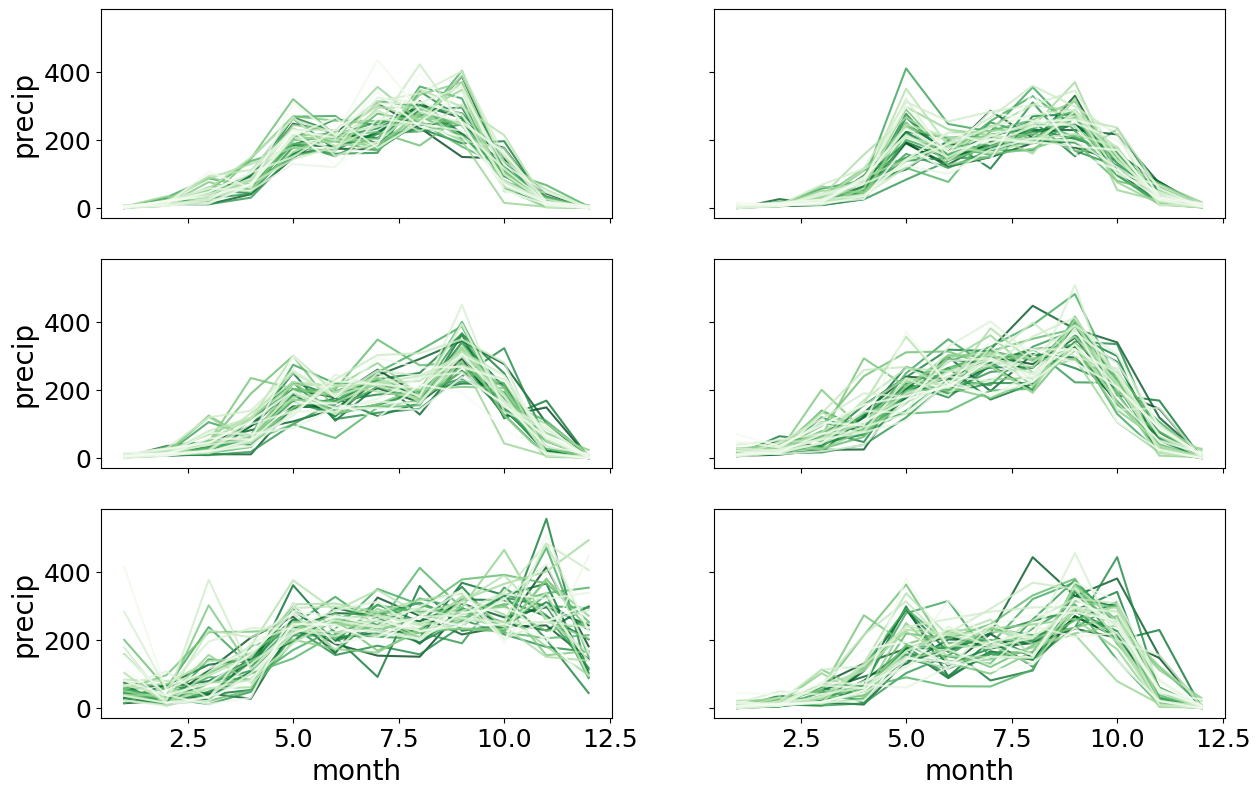

In [75]:
import seaborn as sns

fig, ax = plt.subplots(3, 2, figsize=(14.5, 9.2), sharex=True, sharey=True)

for i_axi, axi in enumerate(ax.flatten()):

    region = regions[i_axi]
    reg_df = reg_resp_df[reg_resp_df.region == region]

    reg_prep_df     =  precipitation_df[precipitation_df.region == region]
    if time_scale == "month":
        reg_prep_df = reg_prep_df.groupby(["year", "month"]).agg({"precip": "sum"}).reset_index()


    sns.lineplot(ax=axi, data=reg_prep_df, x="month", y="precip",
                                                hue     = "year",
                                                alpha   = 0.8,
                                                palette = "Greens_r")
    axi.legend().remove()


In [68]:
reg_prep_df

,year,month,precip
0,1981,1,0.242760
1,1981,2,23.288854
2,1981,3,34.730699
3,1981,4,84.060429
4,1981,5,248.107718
...,...,...,...
463,2019,8,396.547324
464,2019,9,249.453919
465,2019,10,52.834470
466,2019,11,9.931229
